 ## Classification testing workflow

 ### Installation

 <pre>pip install pandas pingouin seaborn matplotlib sklearn</pre>

 We need the development version of scikit-posthocs to get critical difference diagrams

 <pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>



In [5]:
# %%
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef, f1_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import levene
from statsmodels.stats.anova import AnovaRM

 ### 0. Functions

Global variables

In [88]:
metric_ls = ['roc_auc', 'pr_auc', 'mcc', 'recall_pos','recall_neg']

 A few utility functions to make life easier

In [94]:
def recall_at_precision(y_true, y_score, precision_threshold=0.5, direction='greater'):
    if direction not in ['greater', 'lesser']:
        raise ValueError("Invalid direction. Expected one of: ['greater', 'lesser']")

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    thresholds = np.unique(y_score)
    thresholds = np.sort(thresholds)

    if direction == 'greater':
        thresholds = np.sort(thresholds)
    else:  
        thresholds = np.sort(thresholds)[::-1]

    for threshold in thresholds:
        if direction == 'greater':
            y_pred = y_score >= threshold
        else:  
            y_pred = y_score <= threshold

        precision = precision_score(y_true, y_pred)
        if precision >= precision_threshold:
            recall = recall_score(y_true, y_pred)
            return recall, threshold
    return np.nan, None

def calc_classification_metrics(df_in, cycle_col, val_col, prob_col, pred_col):
    metric_list = []
    for k, v in df_in.groupby([cycle_col, "method", "split"]):
        cycle, method, split = k
        roc_auc = roc_auc_score(v[val_col], v[prob_col])
        pr_auc = average_precision_score(v[val_col], v[prob_col])
        mcc = matthews_corrcoef(v[val_col], v[pred_col])
        
        recall_pos, _ = recall_at_precision(v[val_col].astype(bool), v[prob_col], precision_threshold=0.8, direction='greater')
        recall_neg, _ = recall_at_precision(~v[val_col].astype(bool), v[prob_col], precision_threshold=0.8, direction='lesser')

        metric_list.append([cycle, method, split, roc_auc, pr_auc, mcc, recall_pos, recall_neg])
        
    metric_df = pd.DataFrame(metric_list, columns=["cv_cycle", "method", "split",
                                                    "roc_auc", "pr_auc", "mcc", "recall_pos", "recall_neg"])
    return metric_df

def make_boxplots_parametric(df):
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    figure, axes = plt.subplots(1, 5, sharex=False, sharey=False, figsize=(28, 8))
    # figure, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(16, 8))

    for i, stat in enumerate(metric_ls):
        model = AnovaRM(data=df, depvar=stat, subject='cv_cycle', within=['method']).fit()
        p_value = model.anova_table['Pr > F'].iloc[0]
        ax = sns.boxplot(y=stat, x="method", hue="method", ax=axes[i], data=df, palette="Set2", legend=False)
        title = stat.upper()
        if p_value > 0.001:
            ax.set_title(f"p={p_value:.3f}")
        else:
            ax.set_title(f"p<0.001")
        ax.set_xlabel("")
        ax.set_ylabel(title)
    plt.tight_layout()

        
def make_sign_plots_parametric(df):
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    # figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 8))
    figure, axes = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(26, 8))

    for i, stat in enumerate(metric_ls):
        pc = sp.posthoc_tukey(df, val_col=stat, group_col="method")
        sub_ax, sub_c = sp.sign_plot(pc, **heatmap_args, ax=axes[i], xticklabels=True)  # Update xticklabels parameter
        sub_ax.set_title(stat.upper())

def make_mean_ci_plot(df, metric, group_col, xlabel = "metric", ax = None, figsize=(8, 4), title = ""):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=True)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    if ax is None:
        plot = results.plot_simultaneous(xlabel=xlabel, figsize=figsize)
    else:
        plot = results.plot_simultaneous(ax=ax, xlabel=xlabel, figsize=figsize)
    # plot.get_axes()[0].title.set_text(title)

def make_mean_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), 1, figsize=figsize) 
    for i, metric in enumerate(metrics):
        make_mean_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel="", ax=ax[i], figsize=figsize, title="")
    plt.tight_layout()
    for i, a in enumerate(ax):
        a.title.set_text(metric_names[i].upper())

def make_mean_diff_ci_plot(df, metric, xlabel, group_col, ax=None, figsize=(8, 4), title = ""):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=False)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    result_tab = results.summary().data
    columns = result_tab.pop(0)
    result_tab = pd.DataFrame(result_tab, columns=columns)
    result_tab[["meandiff", "lower", "upper"]] = result_tab[["meandiff", "lower", "upper"]] * -1
    result_tab.rename(columns={"lower": "upper", "upper": "lower"}, inplace=True)
    result_tab["group1_mean"] = result_tab["group1"].map(df_means[metric])
    result_tab["group2_mean"] = result_tab["group2"].map(df_means[metric])

    # result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2'] + \
    #                     '\n' + '(' + result_tab["group1_mean"].map("{:.2f}".format) + \
    #                     ' - ' + result_tab["group2_mean"].map("{:.2f}".format) + ')'
    
    result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2']

    result_err = np.array([result_tab['meandiff'] - result_tab['lower'],
                            result_tab['upper'] - result_tab['meandiff']])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.errorbar(y=result_tab.index, x=result_tab['meandiff'], xerr=result_err,
                 fmt='o', capsize=5)
    ax.axvline(x=0, color='black', linestyle='--')
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    if ax is None:
        plt.show()

def make_mean_diff_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), figsize=figsize) 
    for i, metric in enumerate(metrics):
        if i == 0:
            title = 'Multiple Comparison of Means - Tukey HSD, FWER=0.05'
        else:
            title = ""

        make_mean_diff_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel=metric_names[i], ax=ax[i], figsize=figsize, title=title)
    plt.tight_layout()


In [102]:
from matplotlib import colors
from matplotlib.colorbar import ColorbarBase

def sign_plot(pc, effect_size, means, labels=True, cmap=None, cbar_ax=None, cbar_ax_bbox=None,
             ax=None, show_diff=True, cell_text_size=16, axis_text_size = 12, 
             show_cbar=True, reverse_cmap=False, **kwargs):
    pc_copy = pc.copy()
    
    for key in ['cbar', 'vmin', 'vmax', 'center']:
        if key in kwargs:
            del kwargs[key]

    if not cmap:
        cmap = ['1', '#fbd7d4', '#005a32', '#238b45', '#a1d99b']

    pc_copy[(pc < 0.001) & (pc >= 0)] = 1
    pc_copy[(pc < 0.01) & (pc >= 0.001)] = 2
    pc_copy[(pc < 0.05) & (pc >= 0.01)] = 3
    pc_copy[(pc >= 0.05)] = 0

    np.fill_diagonal(pc_copy.values, -1)

    if len(cmap) != 5:
        raise ValueError("Cmap list must contain 5 items")

    # hax = sns.heatmap(df, vmin=-1, vmax=3, cmap=colors.ListedColormap(cmap), center=1, cbar=False, ax=ax, **kwargs)

    significance = pc_copy.copy().astype(object)
    significance[(pc < 0.001) & (pc >= 0)] = '***'
    significance[(pc < 0.01) & (pc >= 0.001)] = '**'
    significance[(pc < 0.05) & (pc >= 0.01)] = '*'
    significance[(pc >= 0.05)] = ''

    np.fill_diagonal(significance.values, '')

    # Create a DataFrame for the annotations
    if show_diff:
        annotations = effect_size.round(3).astype(str)

    hax = sns.heatmap(pc_copy, vmin=-1, vmax=3, cmap=colors.ListedColormap(cmap), annot=annotations, fmt='', cbar=False, ax=ax,
                       annot_kws={"size": cell_text_size}, **kwargs)
    
    if labels:
        hax.set_xticklabels([f'{label.get_text()}\n{means.loc[label.get_text()].round(2)}' for label in hax.get_xticklabels()],
                            size=axis_text_size, ha='center', va='top', rotation=0, rotation_mode='anchor')
        yticklabels = [f'\n{label.get_text()}\n{means.loc[label.get_text()].round(2)}\n\n' for label in hax.get_yticklabels()]
        hax.set_yticklabels(yticklabels, size=axis_text_size, ha='center', va='center', rotation=90, rotation_mode='anchor')
    else:
        hax.set_xlabel('')
        hax.set_ylabel('')

    hax.set_xlabel('')
    hax.set_ylabel('')

    if show_cbar:
        cbar_ax = hax.figure.add_axes(cbar_ax_bbox or [0.95, 0.35, 0.04, 0.3])
        cbar = ColorbarBase(cbar_ax, cmap=(colors.ListedColormap(cmap[2:] + [cmap[1]])), norm=colors.NoNorm(), boundaries=[0, 1, 2, 3, 4])
        cbar.set_ticks(list(np.linspace(0, 3, 4)), labels=['p < 0.001', 'p < 0.01', 'p < 0.05', 'NS'])

        cbar.outline.set_linewidth(1)
        cbar.outline.set_edgecolor('0.5')
        cbar.ax.tick_params(size=0)

    else:
        cbar = None
    return hax, cbar
def make_sign_plot_grid(df, stats, figsize=(20, 10), direction_dict=None,
                          cell_text_size=16, axis_text_size=12, title_text_size=16):
    fig, ax = plt.subplots(2, 3, figsize=figsize) 
    for i, stat in enumerate(stats):
        row = i // 3
        col = i % 3
        pc = sp.posthoc_tukey(df, val_col=stat, group_col="method")
        pc = pd.DataFrame(pc)
        
        # Sort df_means in ascending or descending order based on the direction_dict
        reverse_cmap = False
        if direction_dict and stat in direction_dict:
            if direction_dict[stat] == 'maximize':
                df_means = df.groupby("method").mean(numeric_only=True).sort_values(stat, ascending=False)[stat]
            elif direction_dict[stat] == 'minimize':
                df_means = df.groupby("method").mean(numeric_only=True).sort_values(stat, ascending=True)[stat]
                reverse_cmap = True
            else:
                raise ValueError("Invalid direction. Expected 'maximize' or 'minimize'.")
        else:
            df_means = df.groupby("method").mean(numeric_only=True)[stat]
        # Reindex pc to match the order of df_means
        pc = pc.reindex(df_means.index).reindex(df_means.index, axis=1)

        df_means_diff = pd.DataFrame(index=df_means.index, columns=df_means.index)

        for method1 in df_means.index:
            for method2 in df_means.index:
                if method1 == method2:
                    df_means_diff.loc[method1, method2] = 0
                else:
                    diff = df_means.loc[method1] - df_means.loc[method2]
                    df_means_diff.loc[method1, method2] = diff

        df_means_diff = df_means_diff.astype(float)
        hax, cbar = sign_plot(pc, effect_size=df_means_diff, means=df_means,
                                   show_diff=True, ax=ax[row, col], cbar_ax=None, 
                                   cell_text_size=cell_text_size, axis_text_size=axis_text_size,
                                   reverse_cmap=reverse_cmap)
        # ax[row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        hax.set_title(stat.upper(), fontsize=title_text_size)

    # If there are less plots than cells in the grid, hide the remaining cells
    if len(stats) < 6:
        for i in range(len(stats), 6):
            row = i // 3
            col = i % 3
            ax[row, col].set_visible(False)

    plt.tight_layout(rect=[0, 0, .9, 1])  # Leave space for the colorbar

In [96]:
from matplotlib import cm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def make_curve_plots(df):
    df_plot = df.query("cv_cycle == 0 and split == 'scaffold'").copy()
    color_map = plt.get_cmap('tab10')
    le = LabelEncoder()
    df_plot['color'] = le.fit_transform(df_plot['method'])
    colors = color_map(df_plot['color'].unique())
    val_col = "Sol"
    prob_col = "Sol_prob"

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for (k, v), color in zip(df_plot.groupby("method"), colors):
        roc_auc = roc_auc_score(v[val_col], v[prob_col])
        pr_auc = average_precision_score(v[val_col], v[prob_col])
        fpr, recall_pos, thresholds_roc = roc_curve(v[val_col], v[prob_col])
        precision, recall, thresholds_pr = precision_recall_curve(v[val_col], v[prob_col])

        _, threshold_recall_pos = recall_at_precision(v[val_col].astype(bool), v[prob_col], precision_threshold=0.8, direction='greater')
        _, threshold_recall_neg = recall_at_precision(~v[val_col].astype(bool), v[prob_col], precision_threshold=0.8, direction='lesser')

        fpr_recall_pos = fpr[np.abs(thresholds_roc - threshold_recall_pos).argmin()]
        fpr_recall_neg = fpr[np.abs(thresholds_roc - threshold_recall_neg).argmin()]
        recall_recall_pos = recall[np.abs(thresholds_pr - threshold_recall_pos).argmin()]
        recall_recall_neg = recall[np.abs(thresholds_pr - threshold_recall_neg).argmin()]

        axes[0].plot(fpr, recall_pos, label=f"{k} (ROC AUC={roc_auc:.03f})", color=color, alpha=0.75)
        axes[1].plot(recall, precision, label=f"{k} (PR AUC={pr_auc:.03f})", color=color, alpha=0.75)

        axes[0].axvline(fpr_recall_pos, color=color, linestyle=':', alpha=0.75)
        axes[0].axvline(fpr_recall_neg, color=color, linestyle='--', alpha=0.75)
        axes[1].axvline(recall_recall_pos, color=color, linestyle=':', alpha=0.75)
        axes[1].axvline(recall_recall_neg, color=color, linestyle='--', alpha=0.75)

    axes[0].plot([0, 1], [0, 1], "--", color="black", lw=0.5)
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend()
    plt.tight_layout()

 ### 1. Read Input



 Three models are being compared

 - ChemProp single task (CP_ST)

 - ChemProp multi-task (CP_MT)

 - LightGBM (LGBM)



 Input data columns are

 - cv_cycle - cross validation fold

 - split - split type (random or scaffold)

 - method - the ML method used (CP_ST - ChemProp single task, CP_MT - ChemProp multitask, LGBM - LightGBM)

 - SMILES

 - Name

 - Sol - the ground truth label (1 = Sol inhibitor, 0 = non-inhibitor)

 - Sol_prob - probability returned by the model

 - Sol_pred - prob > 0.5

In [97]:
df_input = pd.read_csv("Sol_classification_ChemProp_LightGBM.csv")

 ### 2. Calculate Classification Metrics

In [98]:
df_metrics = calc_classification_metrics(df_input,
                                         cycle_col="cv_cycle",
                                         val_col="Sol",
                                         prob_col="Sol_prob",
                                         pred_col="Sol_pred")


 Put data from the random splits and scaffold splits into separate dataframes.

In [99]:
# df_random_split = df_metrics.query("split == 'random'").copy()
df_scaffold_split = df_metrics.query("split == 'scaffold'").copy()


 ### 3. Comparing Distributions Across Cross-Validation Folds

In addition to the standard classification metrics AUROC, AUPRC, and MCC, we provide two additional metrics at specific thresholds of interest. These metrics provide context to the area under the curve metrics, which evaluate classifiers at all possible thresholds. The thresholds correspond to two types of filters: 1) a what to make filter and 2) a what NOT to make filter. The thresholds are chosen using the approach described in the decisional impact [notebook](https://github.com/polaris-hub/polaris-experiments/blob/main/notebooks/ADME_example/decisional_impact_metrics.ipynb). 

The two metrics are:

- **Positive class recall (Recall_pos)** at the threshold that maximizes Recall_pos subject to PPV > 80%.
- **Negative class recall (Recall_neg)** at the threshold that maximizes Recall_neg subject to NPV > 80%.



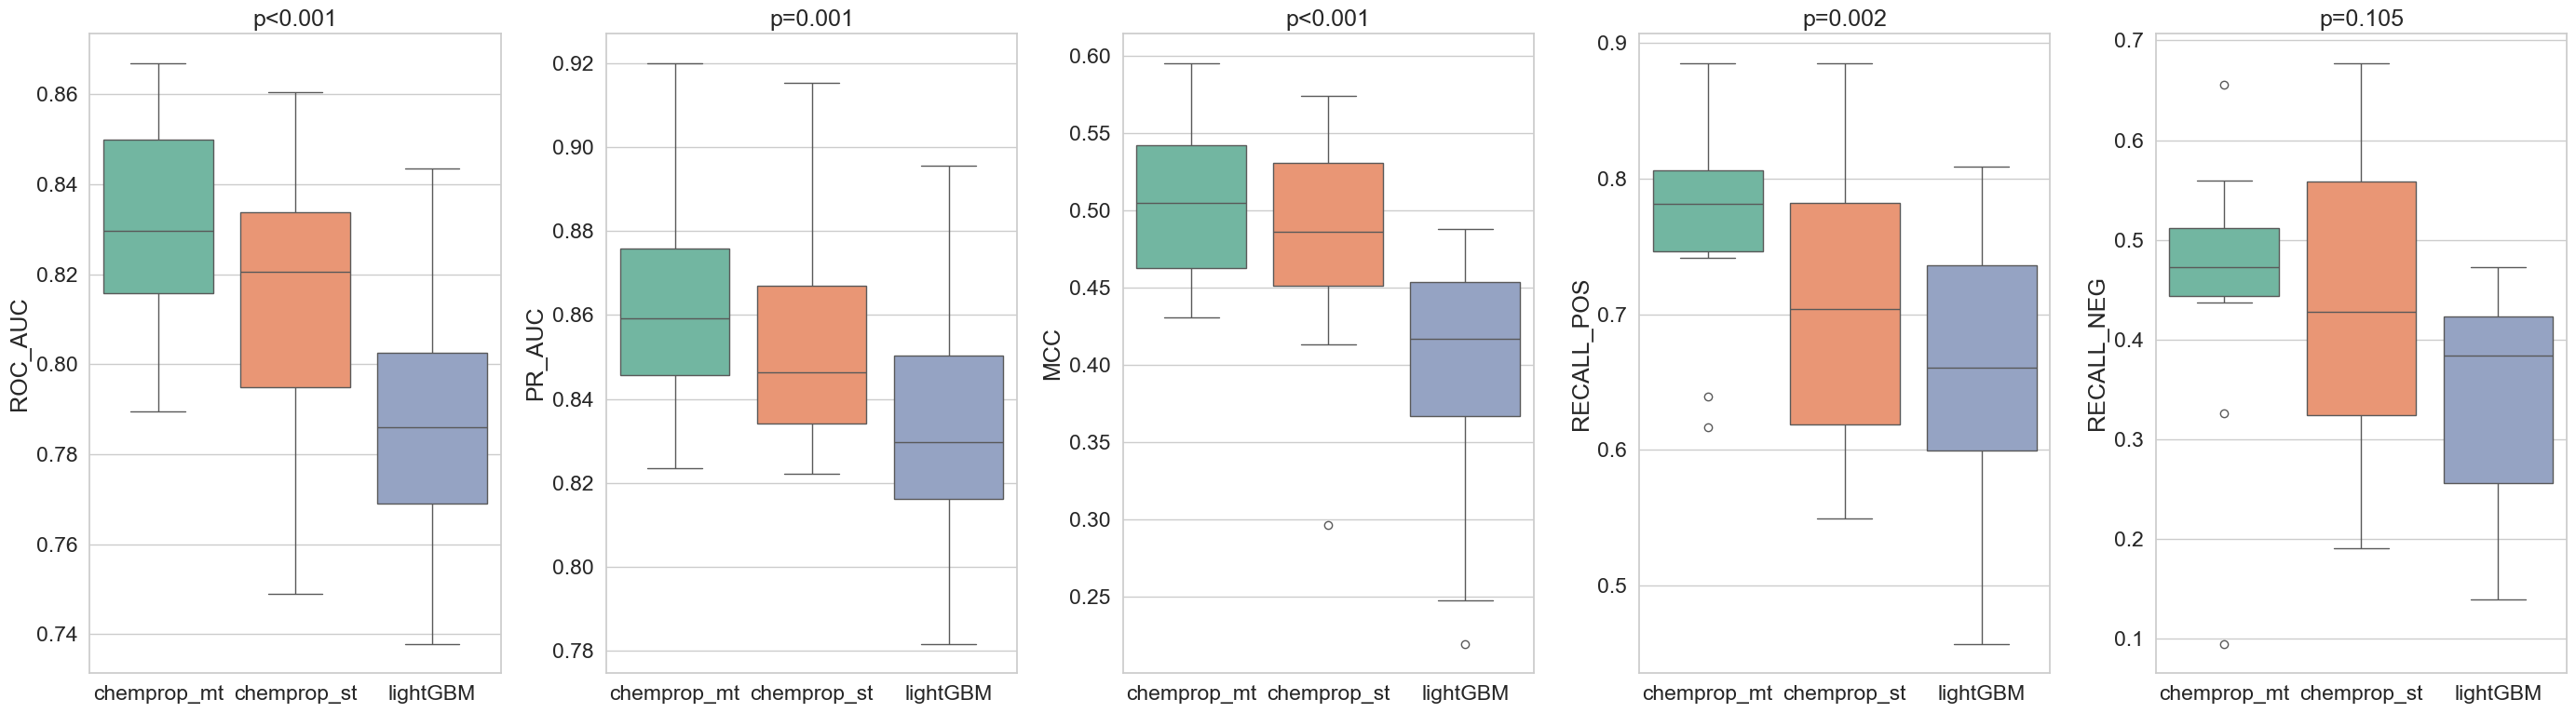

In [100]:
make_boxplots_parametric(df_scaffold_split)

  ### 4. Perform a Post-Hoc Analysis to Examine Differences Between Methods



### 4. Plot the Results of the Post-Hoc Analysis
#### 4.1 Sign Plots

C:\Users\Jash4\AppData\Local\Temp\1\ipykernel_29132\1072183857.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Leave space for the colorbar


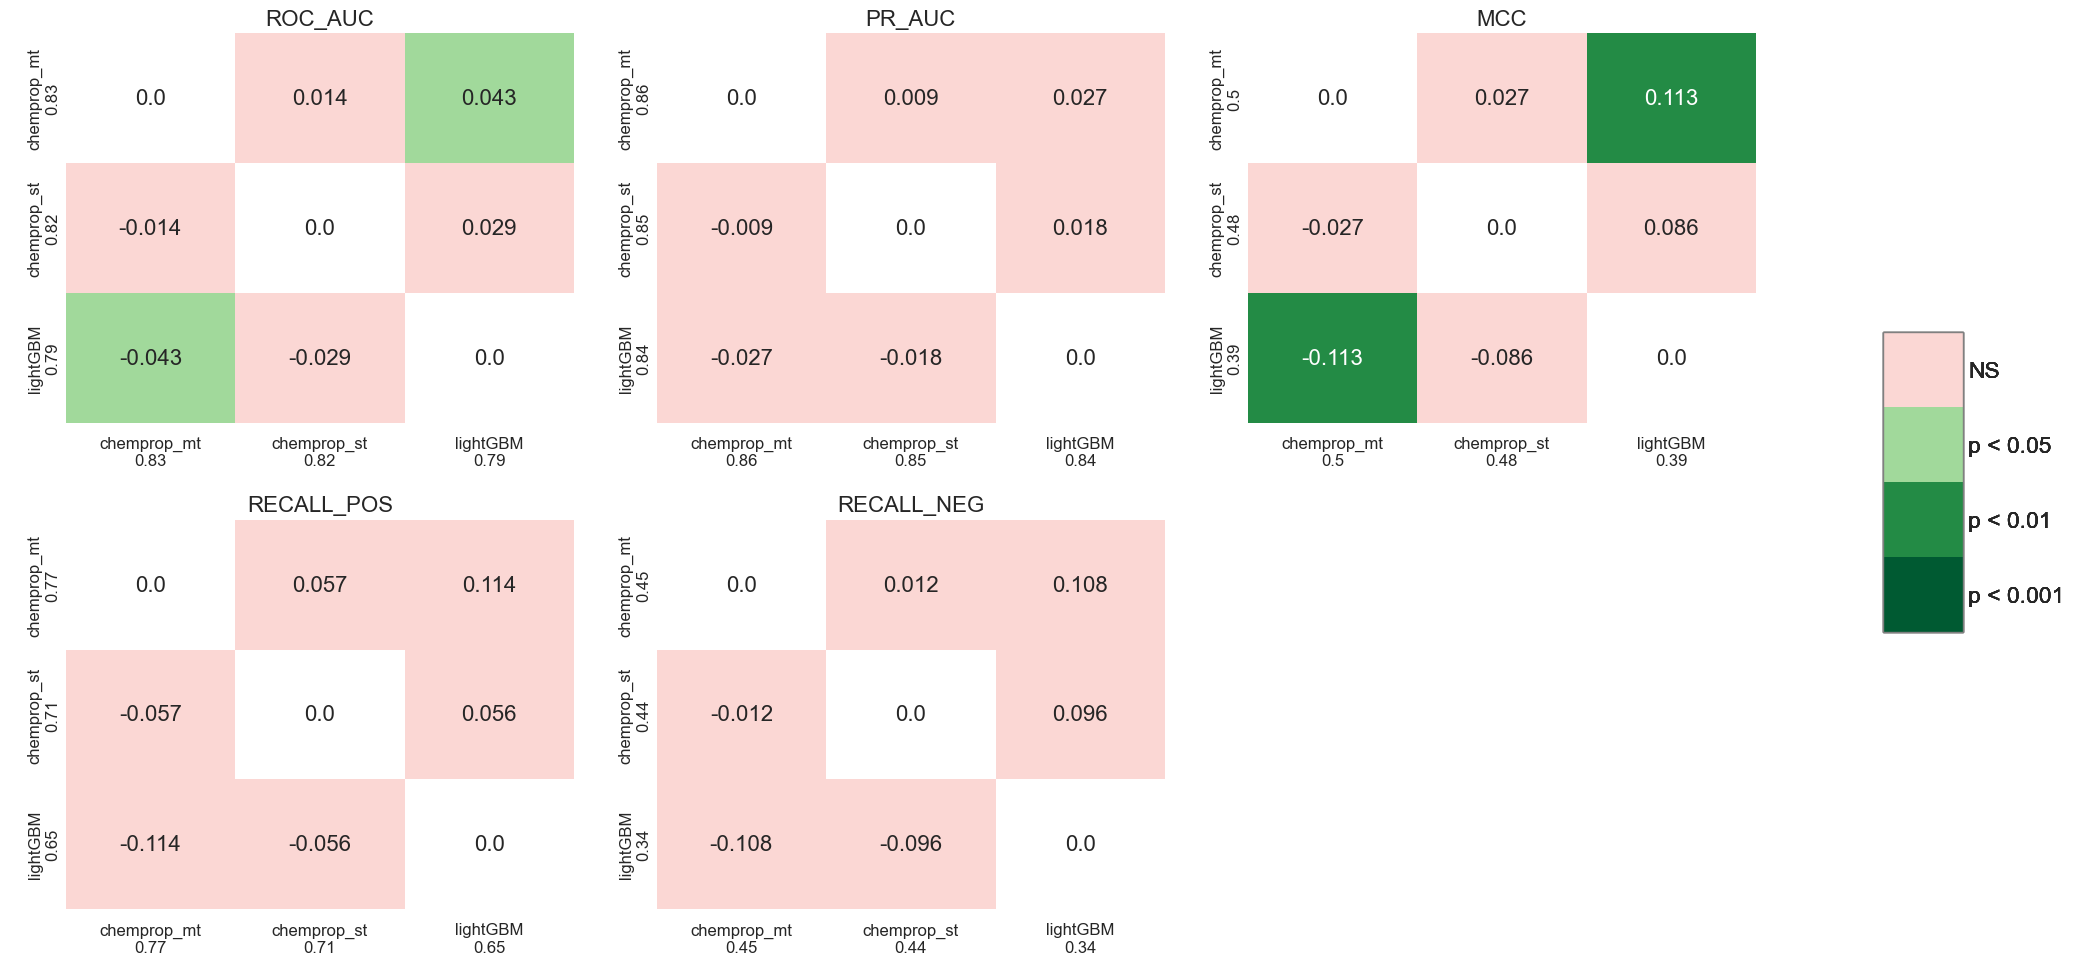

In [103]:
make_sign_plot_grid(df_scaffold_split, metric_ls, figsize=(20, 10))

#### 4.2 Examine if performance differences are actually meaningful by looking at ROC curves

Is the significant difference between the chemprop_mt and lightGBM large enough to be considered practically significant?

To examine this, we map the thresholds of interest on the ROC curve. The dotted vertical lines shows the threshold that maximizes recall_pos subject to PPV > 80%.  The dashed vertical lines shows the threshold that maximizes recall_neg subject to NPV > 80%.

The thresholds of interest map to the two ends of the ROC curve, where there are less differences between the curves.  The largest differences between the curves occur at thresholds which would be unlikely to be used in practice.  

Since there were not significant differences in performance at our thresholds of interest (see sign plots above), we conclude the difference in AUROC is unlikely large enough to be practically meaningful.



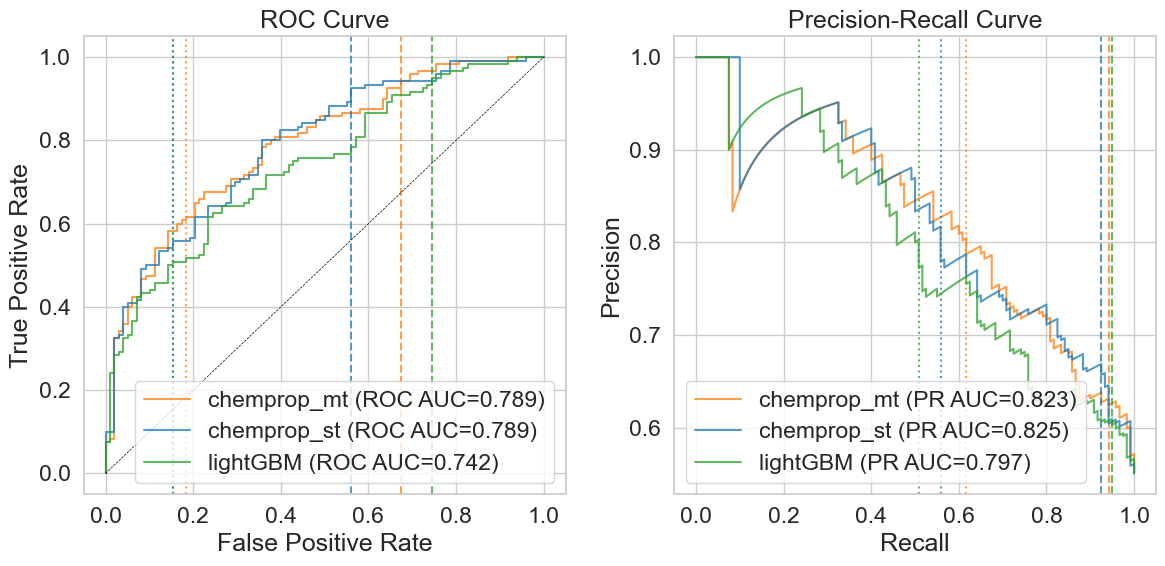

In [106]:
make_curve_plots(df_input)